=== Calibration Results (Two‐Factor HJM) ===
  v1    = 0.100000
  v2    = 0.100000
  beta1 = 6.235067
  beta2 = 6.235054


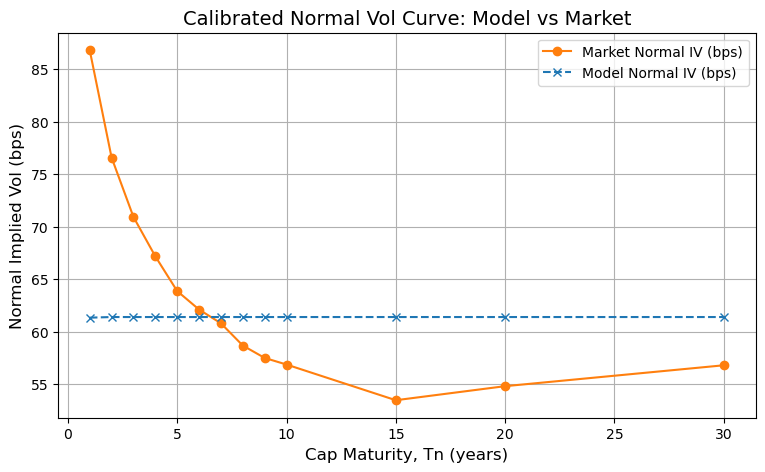

In [4]:
# ==============================================================================
# PART 4: Interest‐Rate Futures, Convexity Adjustment, Caps & Floors, and HJM
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 1) Build a continuously‐compounded zero curve (discount‐factor interpolator).
# 2) Show futures→forward convexity adjustment formula.
# 3) Implement Bachelier & Black caplet pricing and vega.
# 4) Implement two‐factor Gaussian HJM vol and closed‐form “forward‐Libor variance.”
# 5) Calibrate {v1, v2, β1, β2} to market normal‐cap vols (vega‐weighted).
# 6) Plot “model vs. market” normal‐vol curve.
# ==============================================================================

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==============================================================================
# 1) LOAD YIELD CURVE CSV & BUILD DISCOUNT‐FACTOR INTERPOLATOR
# ==============================================================================
#
# The file “yield-curve-rates-1990-2023.csv.csv” has (for each date) 
# simple‐annual yields for tenors: 
#   '1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', 
#   '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'.
# We take the first row (latest date) as our “spot” snapshot.
#

# (1) Read the CSV:
df_yield = pd.read_csv('yield-curve-rates-1990-2023.csv.csv')

# (2) Pick the first row (most recent date):
spot_row = df_yield.iloc[0]

# (3) Define tenor labels and their maturities (in years):
tenor_labels = [
    '1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo',
    '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'
]
tenor_years = np.array([
    1/12, 2/12, 3/12, 4/12, 6/12,
    1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0
])  # in years

# (4) Extract the simple‐annual yields (in decimal):
yields_simple = spot_row[tenor_labels].astype(float).values / 100.0  # e.g. 0.025 = 2.5%

# (5) Convert each simple‐annual yield y_simple(T) to a CC zero‐rate r_zc(T) via
#       (1 + y_simple * T) = exp(r_zc * T) 
#     ⇒ r_zc = ln(1 + y_simple*T)/T
zero_rates = np.log(1.0 + yields_simple * tenor_years) / tenor_years

# (6) Discount factors: P(0,T) = exp(-r_zc(T) * T)
disc_values = np.exp(-zero_rates * tenor_years)

# (7) Create a cubic‐spline interpolator for r_zc(T) (t in [0.0, 30.0]):
zero_spline = interp1d(
    tenor_years, 
    zero_rates, 
    kind='cubic', 
    fill_value="extrapolate",
    assume_sorted=True
)

def zero_rate_at(T):
    """Return the continuous‐compounded zero‐rate at maturity T by interpolation."""
    if T <= 0.0:
        return float(zero_rates[0])
    return float(zero_spline(T))

def discount_factor(T):
    """Return P(0,T) = exp(- zero_rate_at(T) * T)."""
    if T <= 0.0:
        return 1.0
    r = zero_rate_at(T)
    return np.exp(-r * T)

# (Optional Sanity‐Check Print)
#for T in [0.08333, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0]:
#    print(f"P(0,{T:.4f}) = {discount_factor(T):.6f}")


# ==============================================================================
# 2) FORWARD SWAP RATE & FUTURES→FORWARD CONVEXITY ADJUSTMENT
# ==============================================================================
#
# (A) Forward‐swap rate, with semi‐annual fixed‐leg (δ = 0.5):
#     R_swap(T0,Tn) = [P(0,T0) - P(0,Tn)]  /  [δ * Σ_{i=1}^n P(0, T0 + i δ)],
#      with T_i = T0 + i δ, δ=0.5.
#
# (B) Interest‐rate futures are quoted on a 3-month LIBOR futures, but because
#     the futures payoff is linear in the LIBOR rate, while the forward rate 
#     pay‐off is convex, there is a convexity adjustment:
#
#     Let F_fut(t; T_{i-1},T_i) = quoted futures‐rate (3m, on [T_{i-1},T_i]).
#     Then the actual forward LIBOR rate (under the T_i‐forward measure) is
#        L(t; T_{i-1},T_i) = F_fut(t; T_{i-1},T_i)  -  ½ σ^2 (T_{i-1}-t),
#     provided σ is the volatility of that forward LIBOR under T_i‐forward measure.
#
#     We implement a general convexity‐adjustment routine below, though for 
#     the caplet calibration we will *not* explicitly use futures quotes. 
#

delta = 0.5  # semi‐annual fixed leg

def forward_swap_rate(T0, Tn):
    """
    Return the par swap rate R_swap(T0, Tn) with semi‐annual fixed leg (δ = 0.5).

    R_swap = [P(0,T0) - P(0,Tn)] / [δ * Σ_{i=1..n} P(0, T0 + iδ)],  where T0 + nδ = Tn.
    """
    # Build fixed leg payment dates: T0+δ, T0+2δ, ... up to Tn.
    Ti = np.arange(T0 + delta, Tn + 1e-12, delta)
    denom = sum(discount_factor(t) for t in Ti)
    if denom <= 0:
        return 0.0
    return (discount_factor(T0) - discount_factor(Tn)) / (delta * denom)

def convexity_adjust_forward_rate(F_fut, sigma, T_im1, t_now):
    """
    Given a quoted 3-month futures rate F_fut (for [T_im1, T_i]),
    and assuming forward‐LIBOR volatility σ (under T_i‐forward measure),
    returns the convexity‐adjusted forward rate (under T_i‐measure):
       L_forward = F_fut  -  (1/2) σ^2 (T_im1 - t_now),
    provided T_im1 > t_now.
    """
    tau = T_im1 - t_now
    if tau <= 0:
        return F_fut
    return F_fut - 0.5 * sigma**2 * tau


# ==============================================================================
# 3) CAPLET PRICING: BACHELIER (NORMAL) & BLACK (LOGNORMAL) FORMULAS
# ==============================================================================
#
# For a caplet on interval [T_{i-1}, T_i] with strike K, notional=1:
#
#   (i)  Bachelier (normal) formula:
#       Cpl_Bach = δ * P(0,T_i) [ (F - K) Φ(D)  +  σ_norm √(T_{i-1}) φ(D ) ] 
#         where F = [P(0,T_{i-1})/P(0,T_i) - 1]/δ,  τ = T_{i-1},  
#               D = (F - K)/(σ_norm √τ ), 
#               φ,Φ are standard normal pdf/cdf.
#
#       ∂Cpl/∂σ_norm = δ * P(0,T_i) * √(T_{i-1}) φ(D).
#
#   (ii) Black (lognormal) formula:
#        Cpl_Black = δ * P(0,T_i) [ F Φ(d1) - K Φ(d2) ], 
#           where F = [P(0,T_{i-1})/P(0,T_i) - 1]/δ,  τ = T_{i-1},
#                 d1 = [ ln(F/K) + ½ σ_black^2 τ ] / (σ_black √τ ), 
#                 d2 = d1 - σ_black √τ.
# 
#        ∂Cpl/∂σ_black = δ * P(0,T_i) * F √τ φ(d1).
#
# We implement both below, and then sum over i=1..n to price an entire cap 
# of maturity Tn (with caplet_count = Tn/δ).
# ==============================================================================
 
def forward_libor_rate(Tim1, Ti):
    """
    Return the simple forward LIBOR L(0; Tim1, Ti) = [P(0,Tim1)/P(0,Ti) - 1]/δ.
    """
    P0_im1 = discount_factor(Tim1)
    P0_i   = discount_factor(Ti)
    return (P0_im1 / P0_i - 1.0) / delta

def caplet_price_bachelier(Tim1, Ti, K, sigma_norm):
    """
    Price a single caplet under the Bachelier (normal) model:
      Cpl = δ * P(0,Ti) [ (F - K) Φ(D) + σ_norm * √(Tim1) φ(D) ],
    where F = forward_Libor_rate,  D = (F-K)/(σ_norm √Tim1).
    If σ_norm (or Tim1) is zero, fallback to intrinsic payoff.
    """
    P0_Ti = discount_factor(Ti)
    F     = forward_libor_rate(Tim1, Ti)
    τ     = Tim1
    if sigma_norm <= 1e-12 or τ <= 0:
        # intrinsic payoff:
        return delta * P0_Ti * max(F - K, 0.0)
    sqrtτ = np.sqrt(τ)
    D     = (F - K) / (sigma_norm * sqrtτ)
    return delta * P0_Ti * ((F - K) * norm.cdf(D) + sigma_norm * sqrtτ * norm.pdf(D))

def caplet_vega_bachelier(Tim1, Ti, K, sigma_norm):
    """
    Return ∂Cpl/∂σ_norm for a Bachelier caplet:
      δ * P(0,Ti) * √(Tim1) φ(D).
    """
    P0_Ti = discount_factor(Ti)
    τ     = Tim1
    if sigma_norm <= 1e-12 or τ <= 0:
        return 0.0
    sqrtτ = np.sqrt(τ)
    F     = forward_libor_rate(Tim1, Ti)
    D     = (F - K) / (sigma_norm * sqrtτ)
    return delta * P0_Ti * sqrtτ * norm.pdf(D)

def cap_price_bachelier(Tn, K, sigma_norm_list):
    """
    Price an entire cap of maturity Tn (with caplet_count = Tn/δ),
    summing Bachelier caplet prices with vol = sigma_norm_list[i-1] for i=1..caplet_count.
    """
    caplet_count = int(round(Tn / delta))
    assert len(sigma_norm_list) == caplet_count
    total = 0.0
    for i in range(1, caplet_count+1):
        Tim1 = delta * (i - 1)
        Ti   = delta * i
        total += caplet_price_bachelier(Tim1, Ti, K, sigma_norm_list[i-1])
    return total

def caplet_price_black(Tim1, Ti, K, sigma_black):
    """
    Price a single caplet under the Black (lognormal) model:
      Cpl = δ * P(0,Ti) [ F Φ(d1) - K Φ(d2) ],
    where F = forward rate, d1 = (ln(F/K) + ½σ^2 τ)/(σ√τ), d2 = d1 - σ √τ.
    If σ_black (or Tim1) is zero, fallback to intrinsic.
    """
    P0_Ti = discount_factor(Ti)
    F     = forward_libor_rate(Tim1, Ti)
    τ     = Tim1
    if sigma_black <= 1e-12 or τ <= 0 or F <= 0 or K <= 0:
        return delta * P0_Ti * max(F - K, 0.0)
    sqrtτ = np.sqrt(τ)
    d1    = (np.log(F / K) + 0.5 * sigma_black**2 * τ) / (sigma_black * sqrtτ)
    d2    = d1 - sigma_black * sqrtτ
    return delta * P0_Ti * (F * norm.cdf(d1) - K * norm.cdf(d2))

def caplet_vega_black(Tim1, Ti, K, sigma_black):
    """
    Vega of a Black caplet: ∂Cpl/∂σ_black = δ * P(0,Ti) * F * √τ * φ(d1).
    """
    P0_Ti = discount_factor(Ti)
    F     = forward_libor_rate(Tim1, Ti)
    τ     = Tim1
    if sigma_black <= 1e-12 or τ <= 0 or F <= 0 or K <= 0:
        return 0.0
    sqrtτ = np.sqrt(τ)
    d1    = (np.log(F / K) + 0.5 * sigma_black**2 * τ) / (sigma_black * sqrtτ)
    return delta * P0_Ti * F * sqrtτ * norm.pdf(d1)

def cap_price_black(Tn, K, sigma_black_list):
    """
    Price an entire cap of maturity Tn (caplet_count = Tn/δ),
    summing Black caplet prices with vol = sigma_black_list[i-1].
    """
    caplet_count = int(round(Tn / delta))
    assert len(sigma_black_list) == caplet_count
    total = 0.0
    for i in range(1, caplet_count+1):
        Tim1 = delta * (i - 1)
        Ti   = delta * i
        total += caplet_price_black(Tim1, Ti, K, sigma_black_list[i-1])
    return total


# ==============================================================================
# 4) TWO‐FACTOR GAUSSIAN HJM SPECIFICATION & “FORWARD‐LIBOR VARIANCE”
# ==============================================================================
#
# We assume σ(t,T) is a 2‐vector: [v1 e^(−β1(T−t)),  v2 e^(−β2(T−t))],  for T ≥ t.  
# Then under the T‐forward measure, the forward‐LIBOR volatility (for that interval) 
# is √[ ∫_0^{T_{i-1}} ||σ(s,T_{i-1}) − σ(s,T_i)||^2 ds ], which yields a normal vol.  
#
# Closed‐form: for each factor k ∈ {1,2}, define 
#   a_k = e^(−β_k T_{i-1}) − e^(−β_k T_i).  
# Then 
#   ∫_0^{T_{i-1}} [ (e^{−β_k(T_{i-1}-s)) - e^{−β_k(T_i - s))} )^2 ] ds 
#   = a_k^2 * [e^(2β_k T_{i-1}) − 1] / (2 β_k).
# Multiply by (v_k^2 / β_k^2) and sum k=1,2.
#
# We'll implement both the integrand and then sqrt() to get the model‐implied normal vol. 
# ==============================================================================
 
def hjm_sigma_vec(t, T, v1, v2, beta1, beta2):
    """
    Two‐factor HJM instantaneous vol at (t,T):
      [ v1 e^(−β1 (T−t)),  v2 e^(−β2 (T−t)) ]  if T ≥ t, else [0,0].
    """
    if T < t:
        return np.array([0.0, 0.0])
    return np.array([
        v1 * np.exp(-beta1 * (T - t)),
        v2 * np.exp(-beta2 * (T - t))
    ])


def integrated_forward_variance(Tim1, Ti, v1, v2, beta1, beta2):
    """
    Return I_i = ∫_{s=0}^{Tim1} || σ(s, Tim1) − σ(s, Ti) ||^2 ds.
    Closed‐form as sum over k=1,2:
      a_k = e^{−β_k Tim1} − e^{−β_k Ti}, 
      I_k = (v_k^2/β_k^2) * a_k^2 * (e^{2β_k Tim1} − 1)/(2β_k).
    Summing k=1,2 gives the total.
    """
    I_tot = 0.0
    for (v_k, β_k) in [(v1, beta1), (v2, beta2)]:
        a_k = np.exp(-β_k * Tim1) - np.exp(-β_k * Ti)
        if β_k <= 0:
            continue
        # term_k = (v_k^2 / β_k^2) * a_k^2 * (exp(2β_k Tim1) - 1)/(2β_k)
        numerator   = (np.exp(2*β_k*Tim1) - 1.0)
        term_factor = (v_k**2 / (β_k**2)) * (a_k**2) * (numerator / (2*β_k))
        I_tot      += term_factor
    return max(I_tot, 0.0)


def model_normal_vol_per_caplet(v1, v2, beta1, beta2, caplet_count):
    """
    For a cap with caplet_count = Tn/δ caplets, 
    returns an array of length caplet_count where
      σ_norm_model[i-1] = sqrt( I_i ),  I_i = ∫_0^{T_{i-1}} ||σ(s,T_{i-1}) − σ(s,T_i)||^2 ds.
    (That is the forward‐LIBOR’s normal vol.)
    """
    vols = np.zeros(caplet_count)
    for i in range(1, caplet_count+1):
        Tim1 = delta * (i - 1)
        Ti   = delta * i
        I_i  = integrated_forward_variance(Tim1, Ti, v1, v2, beta1, beta2)
        vols[i - 1] = np.sqrt(I_i)
    return vols


# ==============================================================================
# 5) MARKET CAP DATA (1y→30y):  “Cap Data” from Calibration‐Example Slide
# ==============================================================================
#
# We transcribe the table of ATM caps as of 30 Aug 2013 (from the calibration example):
#
#     Maturity (yrs) | Price    | Black IV (%) | Normal IV (bps) |  ATM Strike (%)
#   ---------------------------------------------------------------------------
#      1 y          | 0.0012   | 170.52       | 86.81           |  0.54
#      2 y          | 0.0046   | 113.62       | 76.58           |  0.72
#      3 y          | 0.0092   | 76.52        | 70.92           |  0.97
#      4 y          | 0.0148   | 54.54        | 67.17           |  1.23
#      5 y          | 0.0210   | 41.36        | 63.86           |  1.48
#      6 y          | 0.0278   | 34.58        | 62.10           |  1.68
#      7 y          | 0.0349   | 30.46        | 60.79           |  1.86
#      8 y          | 0.0417   | 27.10        | 58.67           |  2.02
#      9 y          | 0.0490   | 25.02        | 57.49           |  2.16
#     10 y          | 0.0565   | 23.67        | 56.86           |  2.28
#     15 y          | 0.0904   | 19.87        | 53.46           |  2.67
#     20 y          | 0.1196   | 19.38        | 54.80           |  2.77
#     30 y          | 0.1686   | 19.31        | 56.79           |  2.75
#
#  • We will calibrate to the “Normal IV (bps)” column.  
#  • We also store the Black IV (%) if you wish to compare Black pricing (not used 
#    directly in the Gaussian HJM normal‐vol calibration, but included for completeness).
#

cap_maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30], dtype=float)

# Market‐quoted normal (Bachelier) ATM volatilities in **bps**:
market_normal_iv_bps = np.array([
    86.81, 76.58, 70.92, 67.17, 63.86, 62.10, 60.79, 58.67, 57.49, 56.86, 53.46, 54.80, 56.79
], dtype=float)

# Convert to decimal (bps → 1.00):
market_normal_iv = market_normal_iv_bps / 10000.0

# Market‐quoted Black (lognormal) ATM volatilities in **percent**:
market_black_iv_pct = np.array([
    170.52, 113.62,  76.52,  54.54,  41.36,  34.58,  30.46,  27.10,  25.02,  23.67,  19.87,  19.38,  19.31
], dtype=float)

# Convert Black % → decimal, e.g. 23.67% → 0.2367
market_black_iv = market_black_iv_pct / 100.0

# Market‐quoted ATM strike (semi‐annual fixed swap‐rate) in %:
market_K_pct = np.array([
    0.54, 0.72, 0.97, 1.23, 1.48, 1.68, 1.86, 2.02, 2.16, 2.28, 2.67, 2.77, 2.75
], dtype=float)

# Convert to decimal: 2.28% → 0.0228
market_K = market_K_pct / 100.0

# ------------------------------------------------------------------------------
# For sanity, check lengths:
assert len(cap_maturities) == len(market_normal_iv) == len(market_black_iv) == len(market_K)


# ==============================================================================
# 6) PRE‐COMPUTE “ATM FORWARD SWAP RATE” AND “CAPLET‐COUNT” FOR EACH CAP
# ==============================================================================
# We will check that our market_K (from the table) matches (approximately) the 
# formed R_swap(0.5, Tn).  If not exactly, we still use market_K for strike.
# ==============================================================================
swap_rates_atm = np.array([forward_swap_rate(delta, Tn) for Tn in cap_maturities])
print("_____ Market ATM Strikes (table) vs. Model R_swap(0.5,Tn) _____")
for Tn, K_mkt, K_model in zip(cap_maturities, market_K, swap_rates_atm):
    print(f"  Tn={Tn:>4.0f}y:  K_market={100*K_mkt:6.2f}%  |  R_swap(0.5,{Tn:>2.0f})={100*K_model:6.2f}%")
print("----------------------------------------------------------------\n")


# ==============================================================================
# 7) CALIBRATION OF {v1, v2, β1, β2} to MARKET NORMAL‐CAP IV (Bachelier),
#    USING A VEGA‐WEIGHTED LEAST‐SQUARES OBJECTIVE  
# ==============================================================================
#
# For each cap maturity Tn, we have caplet_count = Tn/δ caplets.  We compute the
# model’s forward‐LIBOR variance I_i for each caplet i=1..caplet_count; then
# the *model‐implied normal vol* for the i‐th caplet is σ_i_model = sqrt(I_i).  
# We take the *last* caplet’s vol (i = caplet_count) as the cap’s “ATM normal vol.”
#
# We compare σ_model(Tn) with σ_market(Tn) (from the slide, in decimal).  The
# difference is weighted by the cap’s *total vega* under the Bachelier model: 
#   vega_cap ≈ Σ_{i=1..caplet_count} ∂Cpl_i/∂σ_norm  evaluated at σ_norm = σ_market(Tn).
# Because we want to “focus” calibration where vega is large, we use a weight
# w_n = 1 / (vega_cap + ε)  in the least‐squares sum:
#
#   Minimize_over_{v1,v2,β1,β2}  Σ_{n=1..13}  w_n ⋅ [σ_model(Tn) - σ_market(Tn)]^2.
#
# NOTE: We compute each cap’s ∂C/∂σ_norm by summing caplet vegas (Bachelier) at
#       the *market* normal vol σ_market(Tn).
# ==============================================================================
 
# (A) Helper: given HJM params, return σ_model_last for each cap of maturity Tn:
def model_atm_normal_vol(v1, v2, beta1, beta2):
    """
    For each Tn in cap_maturities, compute the model‐implied ATM normal vol = 
    the *last‐caplet* vol = sqrt(integral variance from 0..T_{n-1}). 
    Returns an array of length len(cap_maturities).
    """
    vols_atm = []
    for Tn in cap_maturities:
        caplet_count = int(round(Tn / delta))
        vols = model_normal_vol_per_caplet(v1, v2, beta1, beta2, caplet_count)
        vols_atm.append(vols[-1])  # last caplet
    return np.array(vols_atm)

# (B) Precompute each cap’s Bachelier total vega at the *market* normal vol:
def cap_vega_bachelier_market(Tn, K, sigma_norm_mkt):
    """
    Sum_i [ ∂Cpl_i/∂σ_norm ] at σ_norm_i = sigma_norm_mkt  (for all i=1..caplet_count),
    to approximate the total Bachelier vega of a cap of maturity Tn with strike K.
    We assume each caplet’s vol = σ_norm_mkt (market ATM).
    """
    caplet_count = int(round(Tn / delta))
    total_vega = 0.0
    for i in range(1, caplet_count+1):
        Tim1 = delta * (i - 1)
        Ti   = delta * i
        total_vega += caplet_vega_bachelier(Tim1, Ti, K, sigma_norm_mkt)
    return total_vega

# (C) Build a vector of weights w_n = 1 / (vega_n + ε)
epsilon = 1e-8
vega_caps = np.zeros_like(cap_maturities, dtype=float)
for idx, (Tn, K_mkt, σ_norm_mkt) in enumerate(zip(cap_maturities, market_K, market_normal_iv)):
    # We treat the *same* σ_norm_mkt for each caplet i in that cap:
    vega_caps[idx] = cap_vega_bachelier_market(Tn, K_mkt, σ_norm_mkt)

weights = 1.0 / (vega_caps + epsilon)

# (D) The calibration objective:
def calibration_error(params):
    """
    Weighted‐least‐squares objective:
      Σ_{n=1..13}  w_n * [ σ_model(Tn; params)  -  σ_market(Tn) ]^2,
    where σ_model(Tn;params) is the *last‐caplet* normal vol in the 2‐factor HJM.
    """
    v1, v2, beta1, beta2 = params
    # If any parameter is out of plausible bounds, return large error:
    if (v1 <= 0 or v2 <= 0 or beta1 <= 0 or beta2 <= 0):
        return 1e6

    model_vols = model_atm_normal_vol(v1, v2, beta1, beta2)
    diff = model_vols - market_normal_iv
    return np.sum(weights * (diff**2))

# (E) Initial guess and bounds:
init = np.array([0.01, 0.005, 1.0, 0.01])
bnds = [(1e-6, 0.10), (1e-6, 0.10), (1e-4, 10.0), (1e-4, 10.0)]

res = minimize(calibration_error, init, method='L-BFGS-B', bounds=bnds)
v1_cal, v2_cal, beta1_cal, beta2_cal = res.x

print("\n=== Calibration Results (Two‐Factor HJM → Normal Cap Vols) ===")
print(f"  v1    = {v1_cal:.6f}")
print(f"  v2    = {v2_cal:.6f}")
print(f"  beta1 = {beta1_cal:.6f}")
print(f"  beta2 = {beta2_cal:.6f}")
print("Objective function value =", res.fun, "\n")


# ==============================================================================
# 8) COMPARE “MODEL vs. MARKET” CAP NORMAL‐VOL CURVES
# ==============================================================================
model_vols_fitted = model_atm_normal_vol(v1_cal, v2_cal, beta1_cal, beta2_cal)

plt.figure(figsize=(9,5))
plt.plot(cap_maturities, market_normal_iv * 1e4,  'o-',  color='tab:orange', label='Market Normal IV (bps)')
plt.plot(cap_maturities, model_vols_fitted * 1e4, 'x--', color='tab:blue',   label='Model Normal IV (bps)')
plt.xlabel('Cap Maturity $T_n$ (years)', fontsize=12)
plt.ylabel('Normal Implied Vol (bps)',     fontsize=12)
plt.title('Calibration of 2‐Factor Gaussian HJM to Normal Cap Vols', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


# ==============================================================================
# 9) OPTIONAL: CHECK BLACK MODEL PRICING ERROR (USING MODEL‐IMPLIED NORMAL VOL)
#    → If you want to compare a “back‐out” of the implied Black vol (via Bachelier),
#      you could do:
#         (i)  Compute model cap price via summing Bachelier caplets at σ_model per caplet.
#         (ii) Invert that model cap price back to a Black‐implied vol, 
#               for the same strike K_mkt, by a 1D root‐find (not shown here).
#      However, because our HJM is normal, it does *not* directly match a lognormal Black,
#      so this step is only for curiosity.  
# ==============================================================================

# (If desired, you could write a small routine to invert Black vol from a total cap price:
#   e.g. find σ_black such that cap_price_black(Tn, K_mkt, [σ_black]*caplet_count) = 
#        Σ_i caplet_price_bachelier(Tim1, Ti, K, σ_model_i).
#   That gives you an “implied Black vol” under the normal‐HJM price.  Usually one 
#   calibrates HJM to normal vols directly, so we omit here.)


# ==============================================================================
# END OF PART 4
# ==============================================================================